In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as  np

dataset, info = tfds.load(
    "oxford_iiit_pet:3.*.*",
    split=["train", "test[:50%]", "test[50%:]"],
    with_info=True
)

dataset_train_original = dataset[0]
dataset_validate_original = dataset[1]
dataset_test_original = dataset[2]
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete98X8EH/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete98X8EH/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpgybyz4crtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

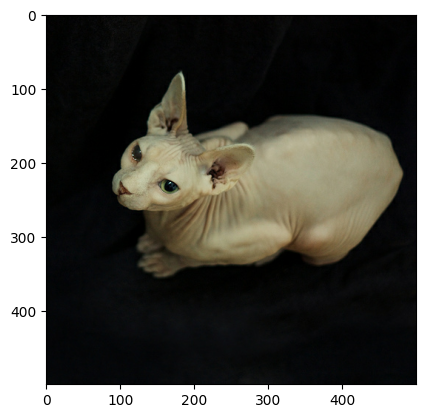

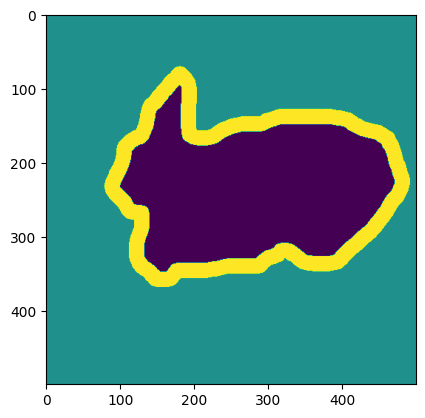

In [ ]:
for sample in dataset_train_original.take(1):
  plt.imshow(sample['image'])
  plt.show()
  plt.imshow(sample['segmentation_mask'])

In [ ]:
for sample in dataset_train_original.take(1):
  classes = np.unique(sample['segmentation_mask'])
  print(classes)

[1 2 3]


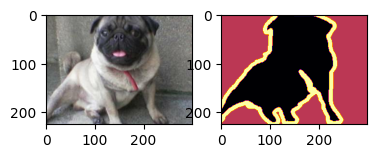

In [ ]:
def render_sample(image, segmentation_mask, predicted_mask=None):
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_mask, cmap="inferno")
    if predicted_mask is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap="inferno")
    plt.show()
    plt.close()

sample = next(iter(dataset_train_original.shuffle(1000).take(1)))
image = sample["image"].numpy()
segmentation_mask = sample["segmentation_mask"].numpy().squeeze()
render_sample(image, segmentation_mask)

In [ ]:
image_size = (200, 200)
nu_classes = 3

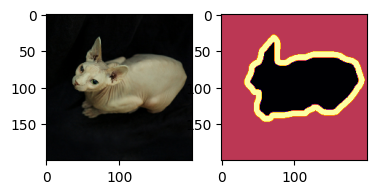

In [ ]:
def encode(sample):
  image = sample['image']
  image = tf.image.convert_image_dtype(image, tf.float32) # Normalize
  image = tf.image.resize(image, image_size) # Resize

  segmentation_mask = sample['segmentation_mask']
  segmentation_mask = tf.image.resize(segmentation_mask, image_size) # Resize
  segmentation_mask = segmentation_mask - 1 # Shifting


  return image, segmentation_mask

dataset = dataset_train_original.map(
    lambda sample: encode(sample)
)
for image, segmentation_mask in dataset.take(1):
  render_sample(image, segmentation_mask)

In [ ]:
# input for a (the) Network: image_size @ 3 for the three classes
# output: image_size and still 3 classes. Network will predict three classes for every pixel!

In [ ]:
dataset_train = dataset_train_original.map(lambda sample: encode(sample)).cache().shuffle(4000).batch(64)
dataset_validate = dataset_validate_original.map(lambda sample: encode(sample)).cache().batch(64)
dataset_test = dataset_test_original.map(lambda sample: encode(sample)).cache().batch(64)

In [ ]:
model = models.Sequential()
model.add(tf.keras.Input(shape=image_size + (3,)))

# Encoder (encoder does not mean that layers size decreases but that stuff gets pushed to latent space)
model.add(layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')) # kernel = 3 equals to (3, 3), system assumes squared window
model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
model.add(layers.Conv2D(128, 3, strides=2, activation='relu', padding='same'))
model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
model.add(layers.Conv2D(256, 3, strides=2, activation='relu', padding='same'))
model.add(layers.Conv2D(256, 3, activation='relu', padding='same'))

# Decoder
model.add(layers.Conv2DTranspose(256, 3, activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(128, 3, activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(64, 3, activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(3, 3, activation='softmax', padding='same'))

model.summary()

model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    dataset_train,
    epochs=50,
    validation_data=dataset_validate
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 256)       295168    
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 25, 256)       590080    
                                                                 
 conv2d_transpose (Conv2DTr  (None, 25, 25, 256)      

1/1 [==============================] - 1s 702ms/step


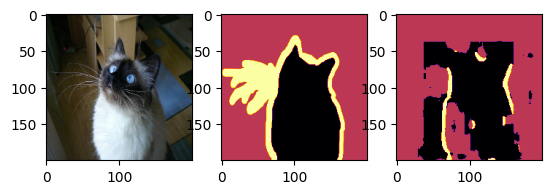

1/1 [==============================] - 0s 20ms/step


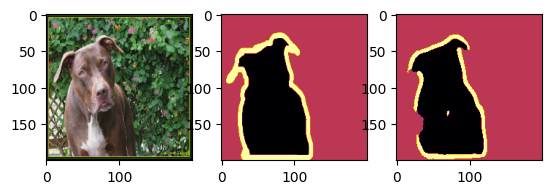

1/1 [==============================] - 0s 18ms/step


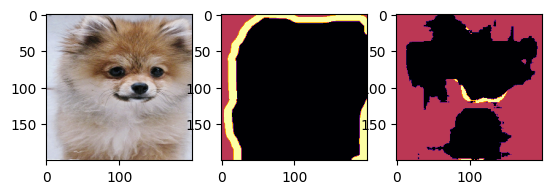

1/1 [==============================] - 0s 21ms/step


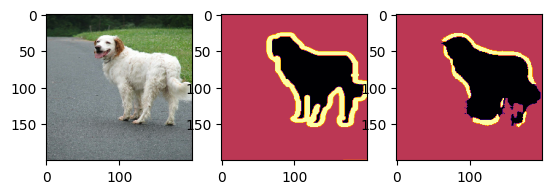

1/1 [==============================] - 0s 19ms/step


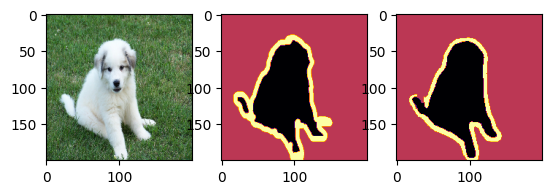

1/1 [==============================] - 0s 17ms/step


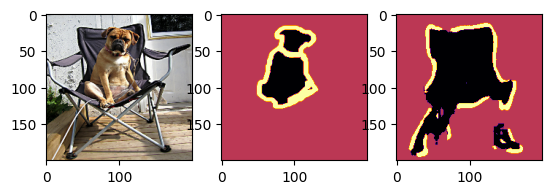

1/1 [==============================] - 0s 30ms/step


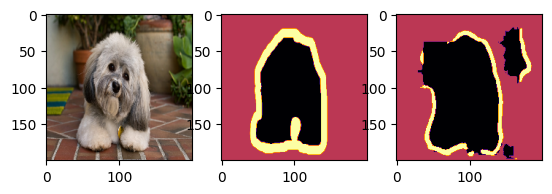

1/1 [==============================] - 0s 36ms/step


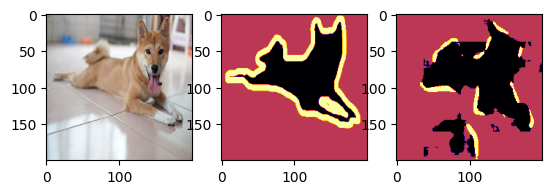

In [ ]:
def render_sample(image, segmentation_mask, predicted_mask=None):
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_mask, cmap="inferno")
    if predicted_mask is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap="inferno")
    plt.show()
    plt.close()

dataset = dataset_test_original.map(lambda sample: encode(sample))
num_samples = 8
for image, segmentation_mask in dataset.take(num_samples):
    image = image.numpy()
    predicted_mask = model.predict(image.reshape((1, 200, 200, 3)))[0]
    predicted_mask = np.argmax(predicted_mask, axis=-1)
    render_sample(image, segmentation_mask.numpy().squeeze(), predicted_mask.squeeze() + 1)